In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import multivariate_normal as mvn
from PIL import Image
import os
import cv2
import time

### Loading the datasets

In [2]:
mnist_df = pd.read_csv('../datat/MNIST_train.csv')
mnist_df.head()

,Unnamed: 0,index,labels,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,0,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,4,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
mnist_df = mnist_df.iloc[:, 2:]
mnist_df.head()

,labels,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#Test set
test_df = pd.read_csv('../datat/MNIST_test.csv')
test_df = test_df.iloc[:, 2:]
test_df.head()

,labels,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
mnist_df.shape

(60000, 785)

In [74]:
mnist_df.isna().sum()

labels    0
0         0
1         0
2         0
3         0
         ..
779       0
780       0
781       0
782       0
783       0
Length: 785, dtype: int64

In [6]:
#train set
X = mnist_df.drop(columns=['labels'], axis=1)
y = mnist_df.labels
X_scaled = X/255
X_scaled = X_scaled.to_numpy()
X_scaled[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [7]:
#preparing the test set
X_test = test_df.drop(columns=['labels'], axis=1)
y_true = test_df.labels

X_test_scaled = X_test/255
 
X_test_scaled = X_test_scaled.to_numpy()
# X_test_scaled[0]

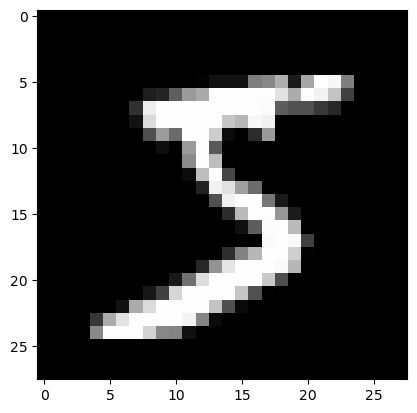

In [8]:
plt.imshow(X_scaled[0].reshape(28, 28), cmap='gray')

### Building Gauss Bayes classifier - Multivariate

In [9]:
class GaussBayes():

  def fit(self, X, y, epsilon=1e-3):
    self.likelihoods = dict()
    self.priors = dict()
    self.K = set(y.astype(int))
    for k in self.K:
      X_k = X[y==k, :]
      N_k, D = X_k.shape
      mu_k = X_k.mean(axis=0)
      sigma_k = (1/(N_k-1))*np.matmul((X_k-mu_k).T, X_k-mu_k) + epsilon* np.identity(D)
      self.likelihoods[k] = {'mean': mu_k, 'cov': sigma_k}
      self.priors[k] = len(X_k)/len(X)

  def predict(self, X):
    N, D = X.shape
    K = len(self.K)
    p_hat = np.zeros((N, len(self.K)))
    for k, l in self.likelihoods.items():
      p_hat[:, k] = mvn.logpdf(X, l['mean'], l['cov']) + np.log(self.priors[k])

    return p_hat.argmax(axis=1)

  def accuracy(self, y, y_pred):
    return (y==y_pred).mean()


In [10]:
#Initialize the classifier
nb_classifier = GaussBayes()
#Training the model
nb_classifier.fit(X_scaled, y, epsilon=1e-3)

In [32]:
#Predict the values using the test data
start_time = time.time()
y_pred = nb_classifier.predict(X_test_scaled)
end_time = time.time()
execution_time = end_time - start_time
print(f"Time of execution is: {execution_time} secs")

Time of execution is: 2.3926315307617188 secs


In [12]:
y_pred[:5]

array([7, 2, 1, 0, 4], dtype=int64)

In [13]:
y_true[:5]

0    7
1    2
2    1
3    0
4    4
Name: labels, dtype: int64

For the first 5 rows, the model perfomed well and produced the actual values

In [14]:
#Checking the accuracy of the model
nb_classifier.accuracy(y_true, y_pred)

0.9108

Before data scaling, the accuracy was 75% but after data scaling, the accuracy improved to 91%

### KNN Classifier

In [17]:
#Testing with KNN classifier
class KNNClassifier():
  #defining training function
  def fit(self, X, y):
    self.X = X
    self.y = y

  #defining prediction function
  def predict(self, X, K, epsilon = 1e-3):
    N = X.shape[0]
    y_hat = np.zeros(N)
     # get squared values outside the loop to reduce computation time
    X_square_sum = np.sum(X**2, axis=1)
    train_square_sum = np.sum(self.X**2, axis=1)
    dist2 = -2 * (X @ self.X.T) + X_square_sum[:, np.newaxis] + train_square_sum
    
    for i in range(N):
        idxt = np.argsort(dist2[i])[:K]
        gamma_k = 1 / (np.sqrt(dist2[i, idxt] + epsilon))
        y_hat[i] = np.bincount(self.y[idxt], weights=gamma_k).argmax()
    
    return y_hat.astype(int)
    
  def accuracy(self, y, y_pred):
    return np.mean((y==y_pred))
     

In [19]:
knn_classifier = KNNClassifier()
knn_classifier.fit(X_scaled, y)

In [37]:
# Use different values of k to find the optimal value with highest accuracy
scores = []
ks = []
start_time = time.time()
for k in range(5, 12):
    y_hat = knn_classifier.predict(X_test_scaled, k)  
    score = knn_classifier.accuracy(y_true, y_hat)
    scores.append(score)
    ks.append(k)
    
end_time = time.time()
execution_time = end_time - start_time
print(f"Time of execution is: {execution_time} secs")
print("k and Scores")
print(ks, scores)

Time of execution is: 465.27787709236145 secs
k and Scores
[5, 6, 7, 8, 9, 10, 11] [0.9691, 0.9709, 0.97, 0.9706, 0.9673, 0.9684, 0.9678]


In [34]:
y_hat[:5]

array([7., 2., 1., 0., 4.])

In [35]:
y_true[:5]

0    7
1    2
2    1
3    0
4    4
Name: labels, dtype: int64

In [39]:
## Knn_score= 0.9691 k-value 5 - time taken  = 47mins - non-optimized,
#Optimal value= 6 (97.09% accuracy)
# Time taken for all values of k=465 secconds

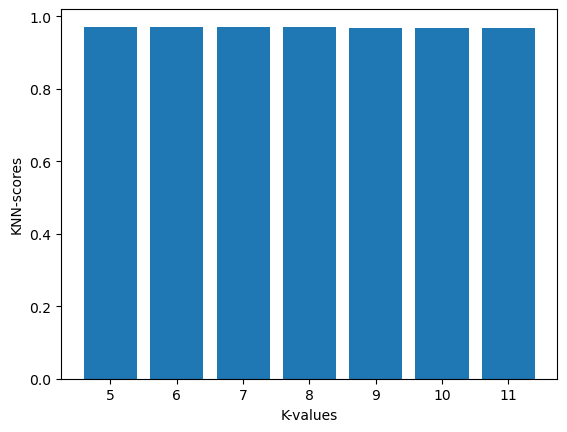

In [42]:
#Visualizing the scores
k = [5, 6, 7, 8, 9, 10, 11]
scores = [0.9691, 0.9709, 0.97, 0.9706, 0.9673, 0.9684, 0.9678]
plt.bar(k, scores) # The differences in scores are minila and thus the bars will look almost the same. 
plt.xlabel("K-values")
plt.ylabel("KNN-scores")
plt.show()

## Use case summary

Invoice and transaction processing of restaurants 
While many restaurants are working on automating and digitizing all transactions, there are so many hotels and restaurants still using the traditional methods of invoicing witha receipt. The receipts come with a section of tips whereby the customer should insert the tip amount and sign. It is a hectic process for employees to collect all receipts and read the numbers inputed in the receipts and add them to the records to charge the customers the extra tip amount. As a result, a new efficient method need to be inplace. The method should be capable of reading handwritten information from the invoices once they have been scanned and put into a computer, extract the values and add to transaction records or database. This GaussBayes classificaton model can solve this problem, reduce the amount of labor, improve effiiciency and reduce time consumed in reading handwritten data. 

###  Testing the model with single handwritten digits 


In [22]:
#Function for resizing the test images to size 28
def resize_convert(image_path, output_path, size=(28, 28)):
  try:
    img = Image.open(image_path)
    img = img.resize(size, Image.Resampling.LANCZOS)
    img.save(output_path)
    
    image_array = np.array(img)
    image_array = image_array / 255 # scaling the data
    image_array = image_array.reshape(1, -1) 
    return image_array
  except IOError as e:
    print(f"Error: {e}. The image was not resized.")

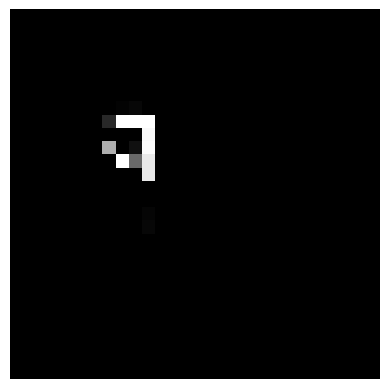

In [72]:
# Read the image in grayscale
img = cv2.imread('../datat/what_9.png', cv2.IMREAD_GRAYSCALE)
blurred = cv2.GaussianBlur(img, (5, 5), 0)

# Darken background and brighten the number - Otsu's thresholding
_, otsu_thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
cv2.imwrite('../datat/what_9_new.png', otsu_thresh) # Save the new image
otsu_thresh_resized = cv2.resize(otsu_thresh, (28, 28), interpolation=cv2.INTER_LANCZOS4)
plt.imshow(otsu_thresh_resized, cmap='gray')
plt.axis('off') 
plt.show()


In [64]:
#Non-naive model
img_array2 = resize_convert('../datat/what_9_new.png', '../datat/what_9_resized.png')
# Predict
predicted_label2 = nb_classifier.predict(img_array2)[0]
print(f"Predicted number: {predicted_label2}")

Predicted number: 7


In [65]:
#KNN model
img_array2 = resize_convert('../datat/what_9_new.png', '../datat/what_9_resized.png')
# Predict
predicted_label3 = knn_classifier.predict(img_array2, 10)[0]
print(f"Predicted number: {predicted_label3}")

Predicted number: 1.0


### Summary and conclusions

The technologies used in this project include Pandas, Numpy, Opencv python, Pillow, matplotlib and seaborn. The technologies helped in loading the dataset, computing for values in arrays, loading and viewing images and visualizing the datasets. I mainly used K-Nearest Neighbor and Non-Naive (Multivariate Gaussian) models in predicting the target values. The data was normalized by dividing all the training and testing X dataset by 255. Below is an analysis of the 2 models based on performance. 

### Model comparison
#### GauseBayes (Multivariate Gaussian NB)
- The model is faster in computing and predicting the values
- Accuracy before normalizing data - 75%
- Accuracy after normalizing data (divide by 255) - 92%

One major downside of this model is that it was trained to only detect sigle digits. In this case, if an image has handwritten values such as 25446, the model detect and print the first detected number. 
To solve this issue, the only possible way is to draw the bounding boxes for each single digit and images representing each number and use the model to extract the numbers. To extract all the numbers without training with bounding boxes, more advanced computer vision technologies such as OCR can be used.

#### KNN Classifier
- Model is slow in predicting the values
- The model has a higher accuracy when the value of k=6 as shown in the results below:
- k-values => [5, 6, 7, 8, 9, 10, 11]
- scores => [0.9691, 0.9709, 0.97, 0.9706, 0.9673, 0.9684, 0.9678]

Based on these results, an increase in the value of k do not significantly improve the accuracyof the model. The optimal value of k is 6 with the highest score of 97.09%.
  
### Conclusion
I chose the KNN model because of the higher accuracy although it speed is slow. This made KNN a suitable model for the Invoice processing use case. If the model is trained on multiple digit dataset, it can efficiently help in extracting handwritten digits from any image. 